In [23]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

In [100]:
def fix_to_range(num, minimum, maximum):
    return minimum if num < minimum else maximum if num > maximum else num

class WealthSim(object):
    def __init__(self, pop=1000, start_wealth=1):
        self.pop = pop
        self.start_wealth = start_wealth
        self.time_step = 0
        self.wealth_fields_order = ["person", "time_step", "wealth"]
        self.wealths = pd.DataFrame(
            [
                {"person": i, "wealth": self.start_wealth, "time_step": self.time_step} for i in range(self.pop)])[self.wealth_fields_order]
        
    def evolve(self, wealth):
        pcnt_change = np.random.normal(loc=0, scale=0.1)
        return wealth + fix_to_range(pcnt_change, -1, 1) * wealth
    
    def step(self, n=1):
        if n == 0:
            return None
        curr_wealths = self.wealths[self.wealths.time_step == self.time_step]
        curr_wealths["wealth"] = curr_wealths.wealth.map(self.evolve)
        self.wealths = pd.concat([self.wealths, curr_wealths.assign(time_step = self.time_step + 1)[self.wealth_fields_order]])
        self.time_step = self.time_step + 1
        self.step(n-1)

In [101]:
sim = WealthSim()

In [102]:
sim.step(100)

/dockvol/wealth_ineq_sim/.venv/lib/python3.6/site-packages/ipykernel_launcher.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [103]:
sim.wealths

,person,time_step,wealth
0,0,0,1.000000
1,1,0,1.000000
2,2,0,1.000000
3,3,0,1.000000
4,4,0,1.000000
...,...,...,...
995,995,100,0.398690
996,996,100,0.628161
997,997,100,0.226708
998,998,100,0.346139


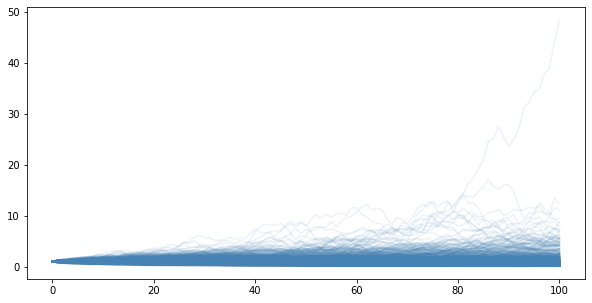

In [104]:
fig, ax = plt.subplots(figsize=(10,5))
for person in sim.wealths.person.unique():
    wealths = sim.wealths[sim.wealths.person == person].sort_values("time_step")
    ax.plot(wealths.time_step, wealths.wealth, color="steelblue", alpha=0.1)

(array([974.,  23.,   2.,   0.,   0.,   0.,   0.,   0.,   0.,   1.]),
 array([2.05643469e-02, 4.86485491e+00, 9.70914548e+00, 1.45534360e+01,
        1.93977266e+01, 2.42420172e+01, 2.90863077e+01, 3.39305983e+01,
        3.87748889e+01, 4.36191794e+01, 4.84634700e+01]),
 <a list of 10 Patch objects>)

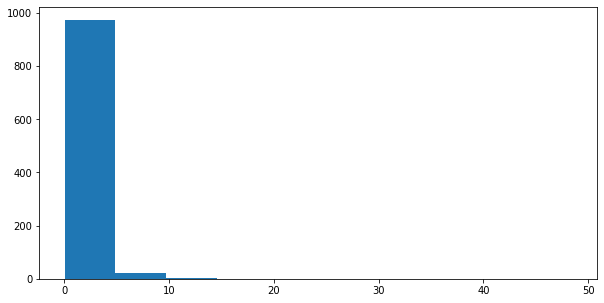

In [105]:
fig, ax = plt.subplots(figsize=(10,5))
ax.hist(sim.wealths[sim.wealths.time_step == sim.time_step].wealth)

In [106]:
sim.wealths["pct_rank"] = sim.wealths.groupby(["time_step"]).wealth.rank(pct=True)

In [107]:
sim.wealths

,person,time_step,wealth,pct_rank
0,0,0,1.000000,0.5005
1,1,0,1.000000,0.5005
2,2,0,1.000000,0.5005
3,3,0,1.000000,0.5005
4,4,0,1.000000,0.5005
...,...,...,...,...
995,995,100,0.398690,0.3480
996,996,100,0.628161,0.5160
997,997,100,0.226708,0.1740
998,998,100,0.346139,0.3030


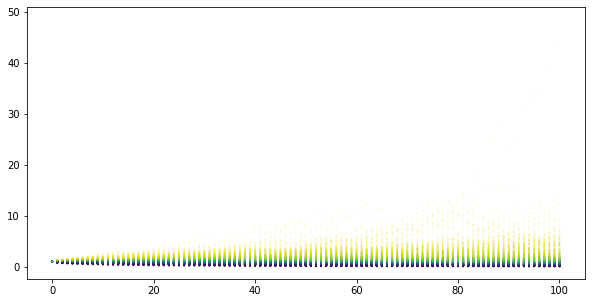

In [108]:
fig, ax = plt.subplots(figsize=(10,5))
for person in sim.wealths.person.unique():
    wealths = sim.wealths[sim.wealths.person == person].sort_values("time_step")
    ax.scatter(wealths.time_step, wealths.wealth, c=wealths.pct_rank, s=1, alpha=0.1)

In [109]:
def group(pct_rank):
    if pct_rank < 0.5:
        return "lower"
    if pct_rank > 0.9:
        return "higher"
    else:
        return "middle"

In [110]:
sim.wealths["class"] = sim.wealths.pct_rank.map(group)

In [111]:
classes = sim.wealths.groupby(["time_step", "class"], as_index = False).wealth.sum()

In [112]:
classes

,time_step,class,wealth
0,0,middle,1000.000000
1,1,higher,117.484708
2,1,lower,459.033537
3,1,middle,422.875910
4,2,higher,124.071891
...,...,...,...
296,99,lower,156.464277
297,99,middle,446.765302
298,100,higher,456.780684
299,100,lower,156.482404


In [113]:
classes["ttl_wealth"] = classes[["time_step"]].merge(
    right = classes.groupby(["time_step"], as_index = False).wealth.sum(),
    on = ["time_step"],
    how="left")["wealth"]
classes["class_pct"] = classes.wealth / classes.ttl_wealth

In [114]:
classes

,time_step,class,wealth,ttl_wealth,class_pct
0,0,middle,1000.000000,1000.000000,1.000000
1,1,higher,117.484708,999.394155,0.117556
2,1,lower,459.033537,999.394155,0.459312
3,1,middle,422.875910,999.394155,0.423132
4,2,higher,124.071891,994.649855,0.124739
...,...,...,...,...,...
296,99,lower,156.464277,1054.668112,0.148354
297,99,middle,446.765302,1054.668112,0.423607
298,100,higher,456.780684,1057.862659,0.431796
299,100,lower,156.482404,1057.862659,0.147923


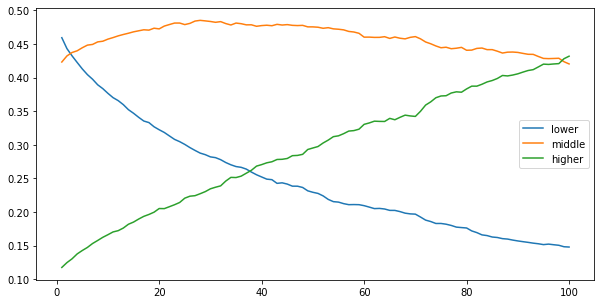

In [115]:
fig, ax = plt.subplots(figsize=(10, 5))
for c in ["lower", "middle", "higher"]:
    class_data = classes[(classes["class"] == c) & (classes.time_step > 0)].sort_values("time_step")
    ax.plot(class_data.time_step, class_data.class_pct, label = c)
ax.legend();